# Text Classification using BERT Experiment
In this notebook, I will create a text classification using BERT and PyTorch. This is an experimental notebook to test whether all the functions I created are working fine. In doing so, I need to make sure that the training time is as fast as possible. If the training code works, I will use it to create a Vertex AI training job so that the model trains on the cloud with much larger dataset.

The training steps I'm going to use are:
1. Read data from BigQuery
2. Preprocess the data
3. Sample the data based on the labels
4. Training and validating for 10 epochs
5. Testing the model using the test data and get the accuracy score

The libraries I used in this project are:
1. PyTorch 2.0 with GPU
2. Transformers
3. Scikit-learn
4. Livelossplot

## Installing additional libraries
Since I created the notebook in the PyTorch 2.0 environment from Vertex AI, I will install the additional libraries I need first, which are transformers and livelossplot. Afterwards, I will restart the kernel.

In [3]:
! pip install transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/1a/d1/3bba59606141ae808017f6fde91453882f931957f125009417b87a281067/transformers-4.34.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 7.4 MB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub<1.0,>=0.16.4 from https://files.pythonhosted.org/packages/aa/f3/3fc97336a0e90516901befd4f500f08d691034d387406fdbde85bea827cc/huggingface_hub-0.17.3-py3-none-any.whl.metadata
  Obtaining dependency information for regex!=2019.12.17 from https://files.pythonhosted.org/packages/8f/3e/4b8b40eb3c80aeaf360f0361d956d129bb3d23b2a3ecbe3a04a8f3bdd6d3/regex-2023.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 6.4 MB/s eta 0:00:00
  Obtaining dependency information for tokenizers<0.15,>=0.14 from https://files.pythonhosted.org/packages/a7/7b/c1f643eb086b6c5c33eef0c3752e37624b

In [4]:
! pip install livelossplot

  Obtaining dependency information for bokeh from https://files.pythonhosted.org/packages/84/60/33f23dbb15fcd785d6287bdd6fa8c9d836dacb40e21c14aad41a57a0ec0f/bokeh-3.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for xyzservices>=2021.09.1 from https://files.pythonhosted.org/packages/b1/2b/53fa918ab16998937586f33d14cb00fbf04ead7425c96b665b73b09c7d64/xyzservices-2023.10.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.0 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 11.1 MB/s eta 0:00:00


## Importing libraries
Basically, there are a few categories of libraries that I used: The standard, plotting, bigquery and storage, pytorch, transformers, and scikit-learn. The other libraries I used are the functions that I wrote previously to make the code cleaner.

In [1]:
#standard librares
import re
import pickle
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import sys

#appending src directory
sys.path.append('../src')

#plotting libraries
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

#bigquery and storage
from google.cloud import bigquery, storage

#pytorch libraries
import torch
import torch.nn as nn
import torch.optim

#transformers libraries
from transformers import BertModel
from transformers import BertTokenizer

#scikit-learn libraries
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#helper functions
import helper
import data
from models import BertClassifier
import optimization
import training

#initializing random seed
random.seed(42)
torch.cuda.manual_seed(42)

## Reading data from BigQuery
I used the function read_data_from_bq found in the ../src/helper.py to read data from BigQuery. The data was uploaded via a .csv file.

In [2]:
#initializing the bigquery URI
bq_uri = 'bq://optimum-pier-401103.bert_chat_dataset.bert-text-use'

#read data from the URI and store it in a pandas dataframe
df = helper.read_data_from_bq(bq_uri)

## Data preprocessing
The steps I'm going to take to preprocess the data are:
1. Simplify the product column using pre-mapped values
2. Convert the rows in the text_col to lowercase
3. Deal with consecutive Xs
4. Remove special characters apart from apostrophe. This is because as far as I know, BERT's subword tokenization can deal with negatives, which often contains apostrophes.
5. Replacing digits. I don't think the digits are necessary in this text classification project.
6. Replacing double spaces with the single ones. The double spaces will be the result of substituting certain parts of the text such as digits.

In doing so, I will use the preprocess_data function found in the ../src/helper.py file.

In [3]:
target_col = 'product'
text_col = 'consumer_complaint_narrative'

df = helper.preprocess_data(df, text_col, target_col)

/home/jupyter/vertex-text-classification/notebook/../src/helper.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({target_col:product_mapping}, inplace=True)
/home/jupyter/vertex-text-classification/notebook/../src/helper.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_col] = df[text_col].str.lower()
/home/jupyter/vertex-text-classification/notebook/../src/helper.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

## Sampling
Next, I will create a sample with the size of 20% from the dataframe. This is to make sure that the training phase runs faster. In the next phase which is creating Vertex AI training job, I will not use sampling so that the model will train on 100% of the data.

In [4]:
#sampling for faster trial training code
sample_size = 0.2

#function to sample each group
def sample_group(group):
    return group.sample(frac=sample_size)

#apply stratified sampling to the dataframe for testing the training code
df_use = df.groupby(target_col, group_keys=False).apply(sample_group)

In [5]:
df_use.head()

,consumer_complaint_narrative,product
305631,i called last month to pnc bank to make sure t...,bank_account
342422,i already filed a complaint with ftc and they ...,bank_account
129739,on my account was closed on and i received a d...,bank_account
672544,i opened a checking account with chase in unde...,bank_account
771047,i got an email from chase saying that my numbe...,bank_account


In [6]:
df_use.shape

(161868, 2)

In [7]:
df_use['product'].value_counts()

product
credit_reporting       69611
debt_collection        31476
mortgage               16892
credit_prepaid_card    16208
personal_loan          11255
bank_account           10455
money_transfer          4019
consumer_loan           1894
others                    58
Name: count, dtype: int64

## Training preparation
### Tokenizing the data
The first step is to tokenize the text column. I will use the pre-trained bert-base-uncased tokenizer since I've converted all the text in the text columns into lowercase. In this project, I don't think that the text is more important if I pay attention to the uppercase and lowercase.

I will tokenize the text column with max_length padding, and predetermie the max_length to 20. The return tensors will be PyTorch tensors since I'm going to use PyTorch in this project.

In [8]:
#loading pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [9]:
#tokenizing the text column
seq_len = 20
tokens = [tokenizer(i, padding="max_length", max_length=seq_len, 
                    truncation=True, return_tensors="pt") 
         for i in df_use[text_col].tolist()]

In [12]:
#output paths
tokens_path = "output/tokens.pkl"
tokens_sample_path = "output/tokens_sample.pkl"
labels_path = "output/labels.pkl"
labels_sample_path = "output/labels_sample.pkl"
model_path = "output/bert_pre_trained.pth"
label_encoder_path = "output/label_encoder.pkl"
label_encoder_sample_path = "output/label_encoder_sample.pkl"

#google storage variables
project_id = 'optimum-pier-401103'
bucket_name = 'text-classification-bucket'

In [13]:
#save the tokens to GCS
helper.save_to_gcs(project_id, bucket_name, tokens_sample_path, tokens)

Variable uploaded to gs://text-classification-bucket/output/tokens_sample.pkl


### Encoding the labels
The label will be encoded using scikit-learn LabelEncoder so that it's easier to feed into the BERT and PyTorch model.

In [14]:
#encoding label
label_encoder = LabelEncoder()
label_encoder.fit(df_use[target_col])
labels = label_encoder.transform(df_use[target_col])

num_classes = len(label_encoder.classes_)
print(f'There are {num_classes} classes to predict')

There are 9 classes to predict


In [15]:
#saving labels and label_encoder
helper.save_to_gcs(project_id, bucket_name, labels_sample_path, labels)
helper.save_to_gcs(project_id, bucket_name, label_encoder_sample_path, label_encoder)

Variable uploaded to gs://text-classification-bucket/output/labels_sample.pkl
Variable uploaded to gs://text-classification-bucket/output/label_encoder_sample.pkl


### Create PyTorch dataloaders
Next, I will create the PyTorch Data Loaders. The steps I'm going to do are:
1. Split the data into training, validation, and testing set.
2. Initialize the dataset using the TextDataset I created before.
3. Create the train, validation, and test data loaders.

The steps will be performed using the function create_dataloaders found in the ../src/data.py file.

In [16]:
#create dataloaders
data_loaders = data.create_dataloaders(tokens, labels,
                                       test_size=0.2, 
                                       valid_size=0.25, 
                                       random_state=42, 
                                       batch_size=16, 
                                       shuffle=False, 
                                       drop_last=False)

There are 97120 training data, and 32374 validation data, and 32374 testing data


## Training the model
These are the steps I'm taking for training the model:
1. Get the loss function
2. Initialize the model
3. Determine the learning rate
4. Get the optimizer
5. Determine the number of epochs
6. Use the optimize function to train the model

For getting the loss function and optimizer, I will use the function get_loss and get_optimizer found in ../src/optimization.py file.

For initializing the model, I will use the BertClassifier class found in ../src/models.py file.

In [18]:
#get loss function
loss = optimization.get_loss()

#initialize model
dropout = 0.5
bert_model = BertClassifier(dropout, num_classes=num_classes, 
                            bert_model_name='bert-base-uncased')

#get optimizer
learning_rate = 1e-3
optimizer = 'adam'
optimizer = optimization.get_optimizer(bert_model, optimizer, learning_rate)
num_epochs = 10

Next, I will use the optimize function found in the ../src/training.py file to train and validate the model. I will train it for 10 epochs only. The best weights will be saved in the GCS and will need to be reloaded later.

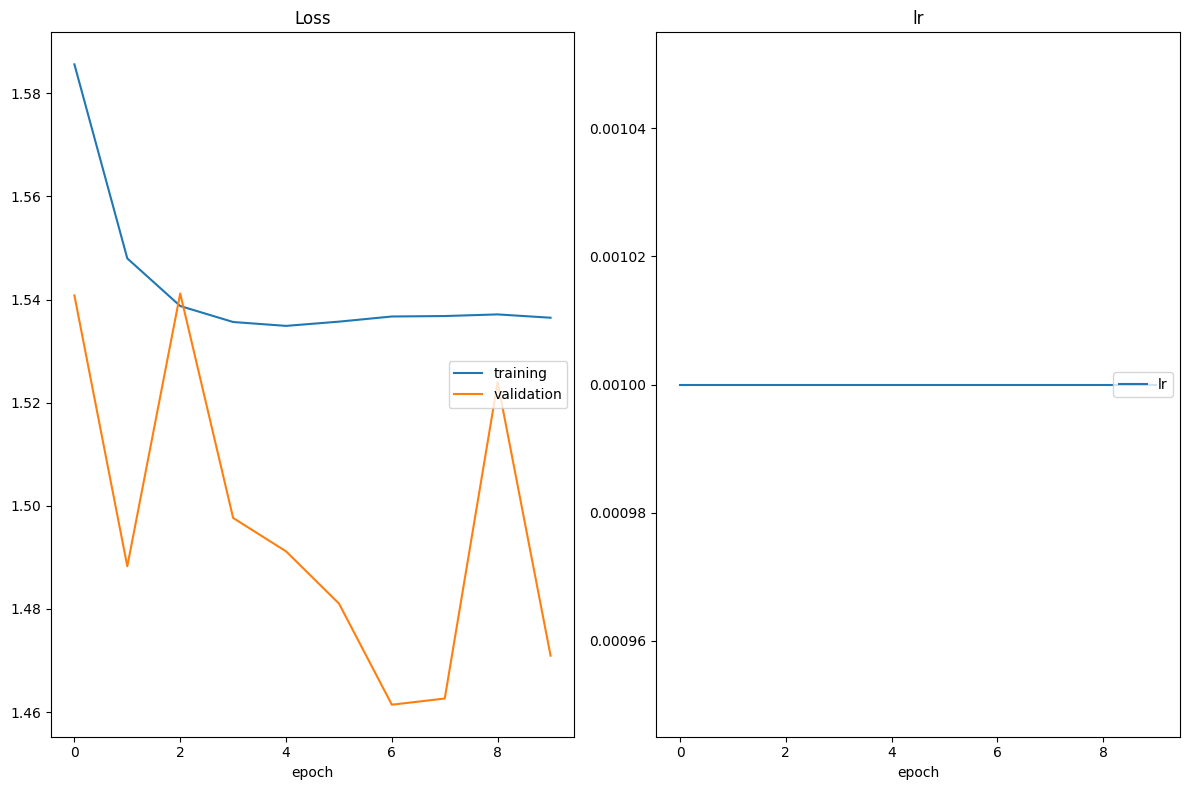

In [19]:
training.optimize(
    data_loaders,
    bert_model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    model_path=model_path,
    interactive_tracking=True
)

## Testing the model against the test dataset
For testing the model, I will do these steps:
1. Create a new model using BertClassifier
2. Download the best model from GCS to local
3. Load the weights to the reloaded model
4. Perform one epoch test using the function one_epoch_test function found in the ../src/training.py file.

In [20]:
reloaded_model = BertClassifier(dropout, num_classes=num_classes, bert_model_name='bert-base-uncased')

In [23]:
# Initialize the GCS client
client = storage.Client()

# Get the bucket
bucket = client.bucket(bucket_name)

# Define the blob (object) where the model is stored
blob = bucket.blob(model_path)

# Download the model to a local file
local_model_path = "best_model.pth"
blob.download_to_filename(local_model_path)

In [24]:
reloaded_model.load_state_dict(torch.load(local_model_path))

<All keys matched successfully>

In [25]:
test_loss = training.one_epoch_test(data_loaders['test'], reloaded_model, loss)

Testing: 100%|██████████████████████████████| 2024/2024 [00:43<00:00, 46.25it/s]

Test Loss: 1.451292


Test Accuracy: 48.36% (15656.0/32374.0)


The model doesn't perform that well, but it's because based on the training graphs, the training and validation loss is still decreasing, and the model hasn't converged well for 10 epochs. In the next step, I will use all dataset and train it for 100 epochs to try to increase the accuracy score of the model.